In [16]:
import json
from pathlib import Path
import pandas as pd

def iter_comment_tree(comment):
    """Recursief door alle replies lopen"""
    yield comment
    for r in comment.get("replies", []):
        yield from iter_comment_tree(r)

data_dir = Path("radical/analyse_fase-kenmerken_onderzoek/Data/reddit_jsons_with_sentiment")  # <-- aanpassen
files = sorted(data_dir.glob("*.json"))

rows = []

for fp in files:
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)

    objects = data if isinstance(data, list) else [data]

    for obj in objects:
        post = obj.get("post", {})

        # ---- POST ----
        rows.append({
            "level": "post",
            "sentiment": str(post.get("sentiment", "")).lower()
        })

        # ---- COMMENTS + REPLIES ----
        for c in obj.get("comments", []):
            for node in iter_comment_tree(c):
                rows.append({
                    "level": "comment_or_reply",
                    "sentiment": str(node.get("sentiment", "")).lower()
                })

df = pd.DataFrame(rows)

print("Totaal rijen:", len(df))
print(df["level"].value_counts())
print(df["sentiment"].value_counts())


Totaal rijen: 43833
level
comment_or_reply    41284
post                 2549
Name: count, dtype: int64
sentiment
neutral          16886
negative         15199
very negative     5819
positive          4203
very positive     1726
Name: count, dtype: int64


In [17]:
order = ["very negative", "negative", "neutral", "positive", "very positive"]

counts = df["sentiment"].value_counts().reindex(order, fill_value=0)
perc = (counts / counts.sum() * 100).round(2)

pd.DataFrame({
    "count": counts,
    "percent": perc
})

,count,percent
sentiment,,
very negative,5819,13.28
negative,15199,34.67
neutral,16886,38.52
positive,4203,9.59
very positive,1726,3.94


In [18]:
pd.crosstab(df["level"], df["sentiment"]).reindex(columns=order)

sentiment,very negative,negative,neutral,positive,very positive
level,,,,,
comment_or_reply,5693,14965,14849,4112,1665
post,126,234,2037,91,61


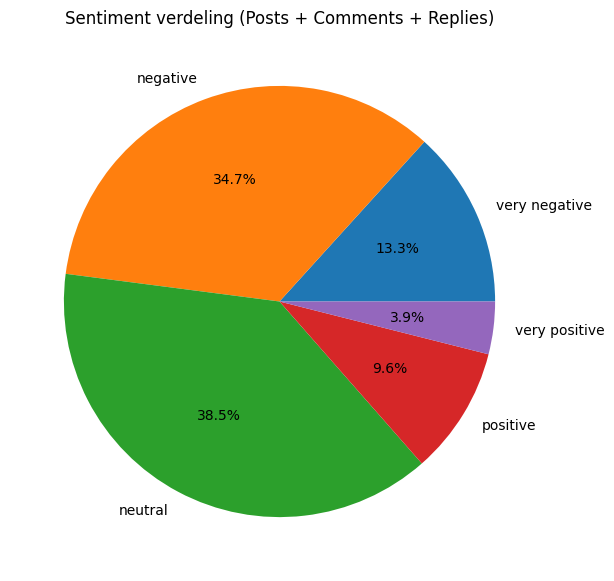

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%")
plt.title("Sentiment verdeling (Posts + Comments + Replies)")
plt.show()

In [20]:
discussion_df = df[df["level"].isin(["comment", "reply"])]

discussion_df["sentiment"].value_counts(normalize=True) * 100

Series([], Name: proportion, dtype: float64)